Le principe est d'attribué à chaque problème une niveau de difficulté en fonction du nombre d'utilisateur l'ayant résolu. À priori, plus un problème est simple, plus il y a de personne capable de le résoudre.

Nous alons testé ce modèle sur un set de problème tiré d'un cours en particulier, et pas sur l'entierté des données dans un premier temps. Cela permetera un validation plus simple du principe de notation. Nous effecturon ensuite un test sur l'entierté des donnée si les résultats sont concluants.

# Sélection des données.

Le cours que nous utiliserons est appelé *Informàtica FME (Tardor 2015)*.

>```sql
test1=# select title from courses where course_id like 'C00198';
             title             
-------------------------------
 Informàtica FME (Tardor 2015)
(1 row)
```

Il est suivi par **77** utilisateurs.

>```sql
test1=# select count(*) from coursesusers where course_id like 'C00198';
 count 
-------
    77
```

Contient **16** listes de problème.

>```sql
    test1=# select count(*) from courseslists where course_id like 'C00198';
 count 
-------
    16
```

Ce qui représente **220** probmèmes

>```sql
test1=# select count(*) from listitems where list_id in (select list_id from courseslists where course_id like 'C00198');
 count 
-------
   220
```



In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import psycopg2

con = psycopg2.connect("dbname=test1")

In [20]:
coures_nm = "C00198"

## Sélection de users

In [28]:
coursesusers = pd.read_sql_query("select user_id from coursesusers where course_id like '%s';" % coures_nm,con=con)

Nous obtenons une liste d'utilisateurs inscrits à ce cours. Mais il est important d'extraire uniquement les utilisateurs "normaux".

In [262]:
userslist = [u[0] for u in coursesusers.values if u[0]]
req = "select user_id from users where demo=0 and instructor=0 and administrator=0\
       and user_id in (%s);" % str(userslist).strip('[]')

usersids = pd.read_sql_query(req, con=con)
usersids.count()

user_id    72
dtype: int64

## Sélection des problèmes

In [263]:
req = "select problem_nm from listitems where list_id in \
        (select list_id from courseslists where course_id like 'C00198');"
probnms = pd.read_sql_query(req, con=con)
probnms.count()

problem_nm    220
dtype: int64

## Sélection des soumissions :
Nous selectionons toutes les soumissions de chaque problème présent dans la liste en filtrant également en fonction des utilisateurs du cours.


In [264]:
pbs = probnms.problem_nm.values.tolist()
usrs = usersids.user_id.values.tolist()
submissions = pd.read_sql_query("select submission_uid, user_id, problem_id, submission_id, \
                        state, time_out, time_in, veredict, score \
                        from submissions where user_id in (%s);" % str(usrs).strip('[]'),
                       con=con)

In [265]:
# Get rid of language ids
submissions.problem_id = submissions.problem_id.apply(lambda x: x[:-3])
submissions.set_index('submission_uid', inplace=True)
submissions.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,25201,25201,25201,25201,25201,25201,25201,135
unique,72,792,44,1,24962,25025,8,17
top,U14908,P71839,S001,done,2015-12-07 00:41:29,2015-12-22 13:45:08,AC,100/100
freq,2357,265,12239,25201,4,2,12206,45
first,NaN,NaN,NaN,NaN,2010-09-15 15:37:19,2010-09-15 10:38:24,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-24 00:05:31,2016-02-24 00:05:22,NaN,NaN


### Soumissions filtrée par la liste de problème contenus dans le cours sélectionné.

In [266]:
submissions = submissions[submissions.problem_id.isin(pbs)]
submissions.count()

user_id          18790
problem_id       18790
submission_id    18790
state            18790
time_out         18790
time_in          18790
veredict         18790
score                0
dtype: int64

In [267]:
goodSubs = submissions[submissions.veredict == 'AC']
goodSubs.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,9344,9344,9344,9344,9344,9344,9344,0.0
unique,72,203,29,1,9295,9299,1,0.0
top,U00214,P68688,S001,done,2015-09-15 14:05:09,2015-10-27 11:35:56,AC,NaN
freq,281,84,5470,9344,2,2,9344,NaN
first,NaN,NaN,NaN,NaN,2010-09-15 15:37:19,2010-09-15 10:45:10,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-23 21:39:42,2016-02-23 21:39:33,NaN,NaN


In [268]:
badSubs = submissions[submissions.veredict != 'AC']
badSubs.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,9446,9446,9446,9446,9446,9446,9446,0.0
unique,70,206,44,1,9381,9418,5,0.0
top,U14908,P34091,S001,done,2015-12-07 00:41:29,2015-12-17 13:25:19,WA,NaN
freq,886,195,3887,9446,4,2,5140,NaN
first,NaN,NaN,NaN,NaN,2010-09-15 15:39:00,2010-09-15 10:38:24,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-23 21:20:31,2016-02-23 21:20:23,NaN,NaN


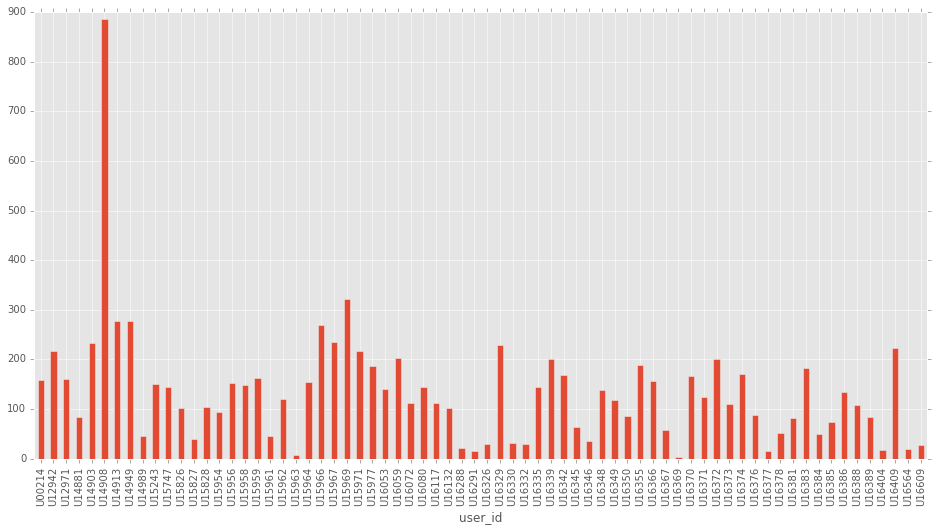

In [269]:
badSubs.groupby('user_id').size().plot(kind='bar', figsize=(16,8))

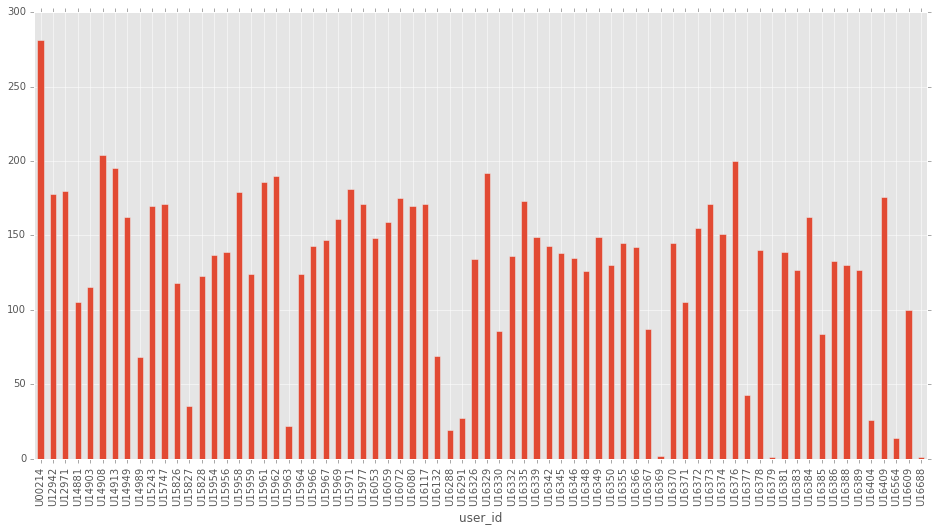

In [270]:
goodSubs.groupby('user_id').size().plot(kind='bar', figsize=(16,8))

In [312]:
g = goodSubs.groupby('user_id').size()

In [313]:
b = badSubs.groupby('user_id').size()

,b_user_id,g_user_id
U00214,159.0,281
U14908,886.0,204
U16376,87.0,200
U14913,278.0,195
U16329,228.0,192
U15962,120.0,190
U15961,46.0,186
U15971,217.0,181
U12971,160.0,180
U15958,148.0,179


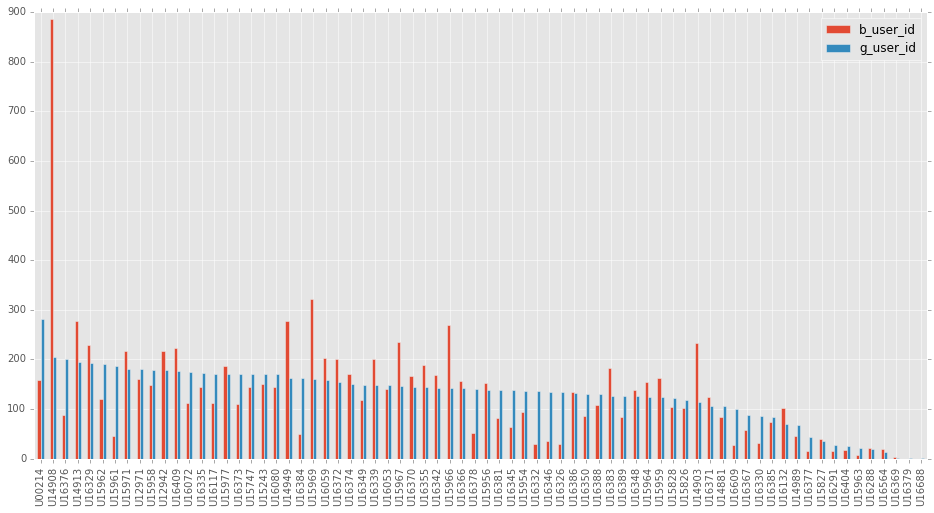

In [340]:
data = pd.DataFrame({'g_user_id': g,'b_user_id':b})
data.sort_values(by='g_user_id', inplace=True, ascending=False)
data.plot(kind='bar', figsize=(16,8))
data.head(10)

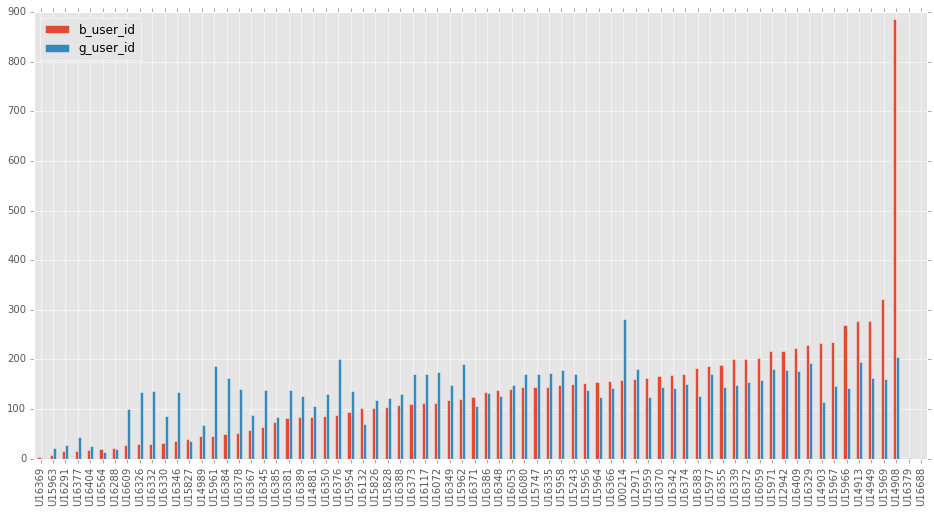

In [369]:
data = pd.DataFrame({'g_user_id': g,'b_user_id':b})
data.sort_values(by='b_user_id', inplace=True, ascending=True)
data.plot(kind='bar', figsize=(16,8))

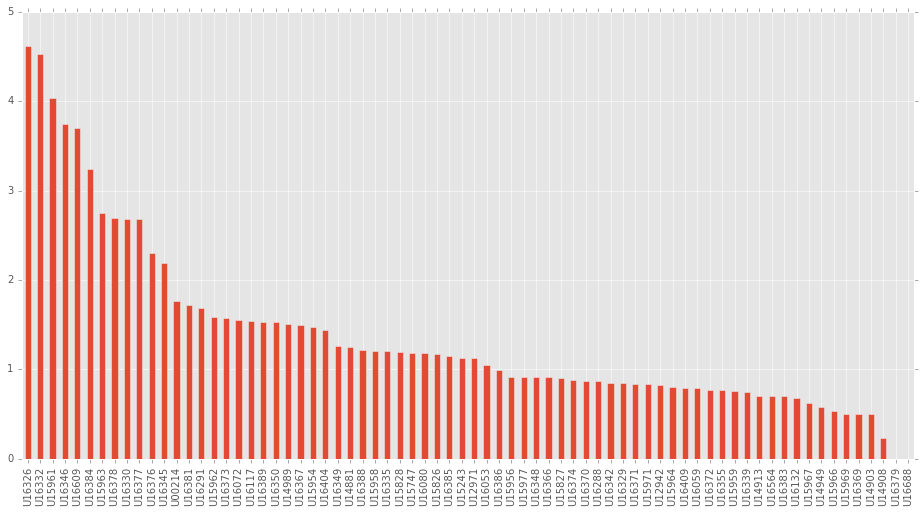

In [371]:
data = pd.DataFrame({'g_user_id': g,'b_user_id':b})
data['ratio'] = data['g_user_id'] / data['b_user_id']
data.sort_values(by='ratio', inplace=True, ascending=False)
data.ratio.plot(kind='bar', figsize=(16,8))

In [372]:
data = pd.DataFrame({'g_user_id': g,'b_user_id':b})
data['ratio'] = data['g_user_id'] / data['b_user_id']

### 10 users with less bad soumission

In [373]:
data.sort_values(by='b_user_id', inplace=True, ascending=False)
data.head(10)

,b_user_id,g_user_id,ratio
U14908,886.0,204,0.230248
U15969,321.0,161,0.501558
U14913,278.0,195,0.701439
U14949,278.0,162,0.582734
U15966,270.0,143,0.529630
U15967,235.0,147,0.625532
U14903,233.0,115,0.493562
U16329,228.0,192,0.842105
U16409,222.0,176,0.792793
U15971,217.0,181,0.834101


### 10 users with more good soumission

In [374]:
data.sort_values(by='g_user_id', inplace=True, ascending=False)
data.head(10)

,b_user_id,g_user_id,ratio
U00214,159.0,281,1.767296
U14908,886.0,204,0.230248
U16376,87.0,200,2.298851
U14913,278.0,195,0.701439
U16329,228.0,192,0.842105
U15962,120.0,190,1.583333
U15961,46.0,186,4.043478
U15971,217.0,181,0.834101
U12971,160.0,180,1.125000
U15958,148.0,179,1.209459


### 10 users with best ratio

In [375]:
data.sort_values(by='ratio', inplace=True, ascending=False)
data.head(10)

,b_user_id,g_user_id,ratio
U16326,29.0,134,4.620690
U16332,30.0,136,4.533333
U15961,46.0,186,4.043478
U16346,36.0,135,3.750000
U16609,27.0,100,3.703704
U16384,50.0,162,3.240000
U15963,8.0,22,2.750000
U16378,52.0,140,2.692308
U16377,16.0,43,2.687500
U16330,32.0,86,2.687500


## Evaluation du niveau de difficulté de chaque problème

Nous utilisons le rapport entre le nombre de soumission acceeptées et rejetées.

Plus un problème est compliqué, plus il faut de tentative sera important.

In [416]:
prob_eval = pd.DataFrame()
prob_eval['goodSubs'] = goodSubs.groupby('problem_id').size()
prob_eval['badSubs'] = badSubs.groupby('problem_id').size()
prob_eval['difficulty'] = prob_eval['badSubs'] / prob_eval['goodSubs']

In [417]:
print prob_eval.info()
print prob_eval.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, P10694 to P99555
Data columns (total 3 columns):
goodSubs      203 non-null int64
badSubs       202 non-null float64
difficulty    202 non-null float64
dtypes: float64(2), int64(1)
memory usage: 6.3+ KB
None
         goodSubs     badSubs  difficulty
count  203.000000  202.000000  202.000000
mean    46.029557   46.589109    1.269516
std     21.564986   36.995824    1.249502
min      1.000000    1.000000    0.018182
25%     28.000000   20.000000    0.485000
50%     54.000000   37.000000    0.846465
75%     64.000000   62.750000    1.512580
max     84.000000  195.000000    8.000000


In [422]:
prob_eval.sort_values(by='difficulty', inplace=True, ascending=False)
prob_eval.difficulty.describe()#.head(10)

count    202.000000
mean       1.269516
std        1.249502
min        0.018182
25%        0.485000
50%        0.846465
75%        1.512580
max        8.000000
Name: difficulty, dtype: float64

In [423]:
prob_eval.head(10)

,goodSubs,badSubs,difficulty
problem_id,,,
P98577,3,24.0,8.000000
P40593,20,143.0,7.150000
P19724,3,17.0,5.666667
P25992,18,97.0,5.388889
P65538,19,93.0,4.894737
P46584,24,117.0,4.875000
P16072,29,128.0,4.413793
P21281,32,139.0,4.343750
P90817,7,29.0,4.142857


In [424]:
prob_eval['difficulty'] = prob_eval['badSubs'] / prob_eval['goodSubs'] * (prob_eval['goodSubs']+prob_eval['badSubs'])

In [426]:
prob_eval.sort_values(by='difficulty', inplace=True, ascending=False)
prob_eval.difficulty.describe()#.head(10)

count     202.000000
mean      132.069621
std       173.355573
min         1.018182
25%        31.891023
50%        63.954706
75%       163.384057
max      1165.450000
Name: difficulty, dtype: float64

In [428]:
prob_eval#.head(10)

,goodSubs,badSubs,difficulty
problem_id,,,
P40593,20,143.0,1165.450000
P34091,63,195.0,798.571429
P21281,32,139.0,742.781250
P16072,29,128.0,692.965517
P46584,24,117.0,687.375000
P43557,37,137.0,644.270270
P99555,33,128.0,624.484848
P25992,18,97.0,619.722222
P65538,19,93.0,548.210526
